In [1]:
%matplotlib inline

Reading a `GeoDataFrame` from a `shapefile`
-------------------------------------------------------------------------

First, lets define some imports:

In [2]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

We use the `shapefile` set ``states_21basic`` to map the US States and get their geometries. Lets load the data into a ``GeoDataFrame``:

In [3]:
usa = geopandas.read_file("states_21basic/states.shp")

Check out the ``head`` of the `DataFrame`:

In [4]:
usa.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


The geometry column contains POLYGON shapes! These polygons are a tuple of longitude/latitude points that make up the border of each US state. We’ve already got enough info to make a basic plot:

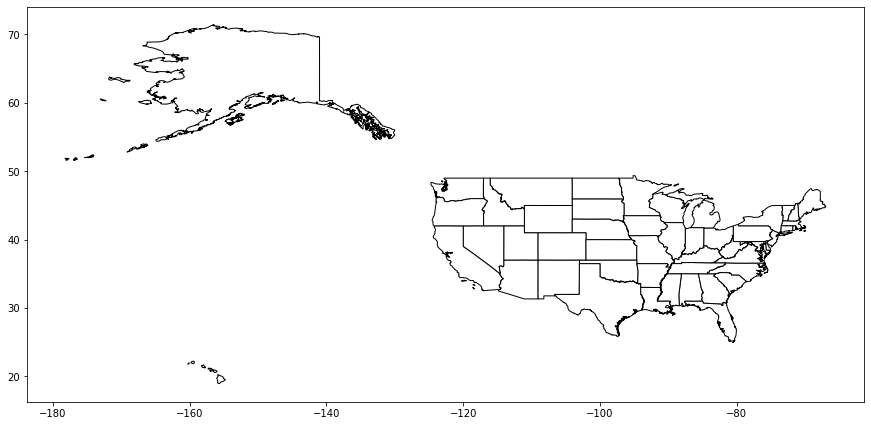

In [5]:
usa.plot(color='white', edgecolor='black')

You can check out individual states:

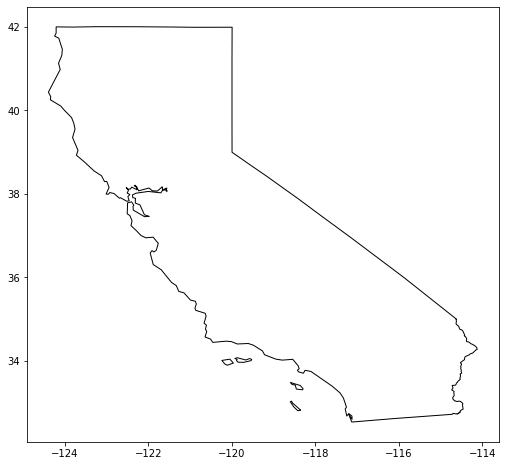

In [6]:
usa[usa.STATE_ABBR == 'CA'].plot(color='white', edgecolor='black')

Creating a GeoDataFrame from a DataFrame with coordinates
-------------------------------------------------------------------------

Create a ``GeoDataFrame`` when starting from a *regular* ``DataFrame`` that has coordinates in WKT format.

A ``GeoDataFrame`` needs a ``shapely`` object:

In [7]:
from shapely import wkt

We use the `geo_sparql_query` module to retrieve the `DataFrame` instance holding collection of WKT we would like to plot.

In [8]:
from geo_sparql_query import get_local_gid_df, get_osm_df

Set the GID (Global Identifier) of the segment you would like to inspect (an identifer of a specific segment in our knowledge graph, accessed using a `SPARQL` query behind the scenes).

__Note:__
_Please make sure that the `SPARQL` endpoint of your linked-maps-style knowledge graph is active. You can run the following command to initiate the triplestore (and the `SPARQL` endpoint) from `apache-jena-fuseki`'s root directory like this: <br />
`./fuseki-server --file /linked-maps/bray_data/bray.linked_maps.ttl /linkedmaps`_

In [9]:
INSPECTED_GID = 75

Retrieve the `DataFrame`:

In [10]:
wkt_df = get_local_gid_df(INSPECTED_GID)

We use ``shapely.wkt`` sub-module to parse wkt format:

In [11]:
wkt_df['Coordinates'] = wkt_df['Coordinates'].apply(wkt.loads)

Lets inspect the ``GeoDataFrame``:

In [12]:
gdf = geopandas.GeoDataFrame(wkt_df, geometry='Coordinates')
gdf.insert(0, 'OSM', 0)

gdf.head()

,OSM,GID,Instance,Coordinates,Label,Types
0,0,http://linkedmaps.isi.edu/75,None,"MULTILINESTRING ((-121.99552 41.72220, -121.99...",None,None


We can plot our ``GeoDataFrame`` on top of a state (which we parsed from the `shapefile`):

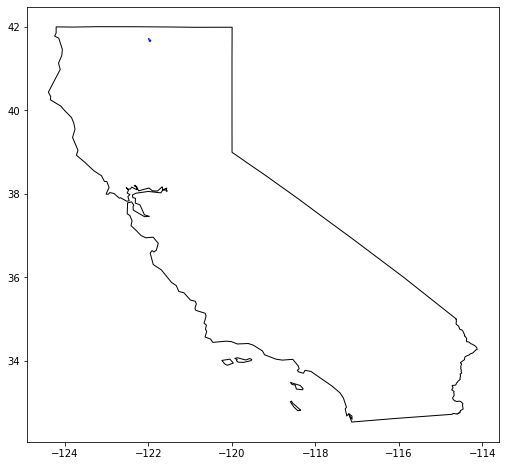

In [13]:
ax = usa[usa.STATE_ABBR == 'CA'].plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='blue')

Or as a standalone (no state borders):

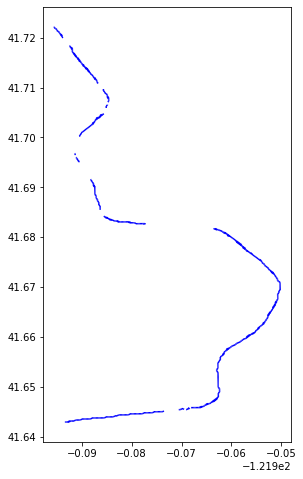

In [14]:
gdf.plot(color='blue')

Now, lets retrieve the `DataFrame` instance holding the collection of WKT literals that correspond to our data in LinkedGeoData Knowledge Base (also accessed using a `SPARQL` query behind the scenes):

In [ ]:
osm_df = get_osm_df(INSPECTED_GID)

Lets do simple manipulations to convert our `DataFrame` to `GeoDataFrame` and allow us to show plots of both frames in the same plot (by inserting an additional column):

In [ ]:
osm_df['Coordinates'] = osm_df['Coordinates'].apply(wkt.loads)
osm_gdf = geopandas.GeoDataFrame(osm_df, geometry='Coordinates')
osm_gdf.insert(0, 'OSM', 1)

Lets inspect the `GeoDataFrame` and plot it:

In [ ]:
osm_gdf.head()

In [ ]:
osm_gdf.plot(color='red')

Lets concat both `GeoDataFrame`s to plot them together:

In [ ]:
frames = [gdf, osm_gdf]
result = pd.concat(frames)
result

In [ ]:
result.plot(column='OSM', cmap='bwr')

We can add a basemap:

In [ ]:
#TODO: fix
#import contextily as ctx

#result.crs = {'init' :'epsg:4326'}  
#ax = result.to_crs(epsg=3857).plot(column='OSM', cmap='bwr')
#ctx.add_basemap(ax)

We can also export our table data to an excel file:

In [ ]:
osm_gdf.to_excel("geolinking_results_g.xlsx") 

And we can plot each 'distant' instance (from LinkedGeoData) separately (each time with our `INSPECTED_GID`):

In [ ]:
for idx in range(len(osm_gdf.index)):
    osm_inst_uri = osm_gdf.iloc[idx]['Instance']
    sub_osm_gdf = osm_gdf[osm_gdf.Instance == osm_inst_uri]
    frames = [gdf, sub_osm_gdf]
    result = pd.concat(frames)
    #print(sub_osm_gdf.iloc[0]['Types'])
    result.plot(column='OSM', cmap='bwr')

Writing a `shapefile` from a `GeoDataFrame`
-------------------------------------------------------------------------

First let define some `WKT` coordinates and insert them into a `GeoDataFrame`

In [ ]:
MDR_ARTIFICIAL_DATA = ['LINESTRING (-118.44259500278235 33.98456150282233,-118.43306779636146 33.975842755729126,-118.428304193151 33.98196376558386)',
                       'LINESTRING(-118.41718911899329 33.99580558664377,-118.43306779636146 33.975842755729126,-118.42637300266028 33.966055341841916)',
                       'LINESTRING(-118.44877481235267 33.957939831868956,-118.43306779636146 33.975842755729126,-118.41367006076575 33.95366819986043)',
                       'LINESTRING(-118.44087838901282 33.96676719174423,-118.43315362704993 33.975771578603826,-118.45212220920325 33.994382367142336,-118.44508409274817 33.998865427838126)']

In [ ]:
mdr_df = pd.DataFrame(columns=['GID', 'Instance', 'Coordinates', 'Label', 'Types'])
mdr_df = mdr_df.append({'GID': 'http://linkedmaps.isi.edu/TEST1',
                        'Instance': None,
                        'Coordinates': MDR_ARTIFICIAL_DATA[3], #0-3
                        'Label': None,'Types': None}, ignore_index=True)

We use ``shapely.wkt`` sub-module to parse wkt format:

In [ ]:
mdr_df['Coordinates'] = mdr_df['Coordinates'].apply(wkt.loads)

Lets inspect the resulting ``GeoDataFrame`` and plot it:

In [ ]:
mdr_gdf = geopandas.GeoDataFrame(mdr_df, geometry='Coordinates')
mdr_gdf.head()

In [ ]:
mdr_gdf.plot(color='blue')

set the CRS (Coordinate Reference System):

In [ ]:
mdr_gdf.crs = {'init' :'epsg:4326'} 

Now lets write it to a `shapefile`:

In [ ]:
mdr_gdf.to_file(driver = 'ESRI Shapefile', filename= "maps_artificial_data/1903.shp")